# Demo of Generalized Fisherface

This notebook shows a quick demo of the Generalized Fisherface method via the implementation of the Generalized Fisher's Linear Discriminant in `generalized_fisher_ld.py`

Notes:
- in the implementation of standard fisherface, often (depending on $N$, $c$, and $n$) an initial PCA is necessary to avoid non-singular matrices for fisher's linear discriminant. For generalized Fisherface with $\alpha > 0$, this is no longer necessary.
- it seems fisherface is suceptible to overfitting. in my intial tests, it would often get 100% train accuracy, but poor test accuracy.
- similar to eigenface, fisherface has visually-interpretable 'fisherfaces' which come out of the generalized eigenvector problem. Similarly, generalized fisherface also has visually-interpretable 'generalized-fisheraces' coming out of the generalized eigenvector problem.

**Note-to-self:** look at the comments I put while developing. There are a few things I need to add/change/test.
I also come back and add more notes to this or create a dedicated documentation page or something...

## Set up

In [1]:
import numpy as np
import sklearn.pipeline
import matplotlib.pyplot as plt

In [2]:
# load data
import sklearn.datasets
from sklearn.model_selection import train_test_split


lfw_people = sklearn.datasets.fetch_lfw_people(min_faces_per_person=70, resize=0.4)

n_samples, h, w = lfw_people.images.shape
target_names = lfw_people.target_names
n_classes = target_names.shape[0]

X = lfw_people.data
n_features = X.shape[1]

y = lfw_people.target


print("Total dataset size:")
print("n_samples: ",  n_samples)
print("n_features: ", n_features)
print("n_classes: ", n_classes)



# split into a training and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# first, scale the data
scaler = sklearn.preprocessing.StandardScaler().fit(X_train)
X_train_trfm = scaler.transform(X_train)
X_test_trfm = scaler.transform(X_test)

n_samples_train = len(X_train)

Total dataset size:
n_samples:  1288
n_features:  1850
n_classes:  7


In [3]:
def plot_faces(faces, n_cols=3, figsize=(8,6), h=h, w=w):

    dim, n_faces = faces.shape
    n_rows = n_faces // n_cols
    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)

    for i, ax in enumerate(axes.flatten()):
        ax.imshow(faces[:, i].reshape(h,w))

    return fig, ax

In [4]:
from generalized_fisher_ld import GeneralizedFisherLD

## Generalized Fisherface ($\alpha = 0$)

For $\alpha=0$, we reduce to standard fisherface. Recall that for standard fisherface, we first need to perform PCA to avoid signular matrices in the generalized eigenvector problem.

In [5]:
import sklearn.pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA

fld_clf = sklearn.pipeline.Pipeline(steps=[('pca', PCA(n_components = n_samples_train - (n_classes - 1))),
                                           ('fld', GeneralizedFisherLD(n_components=n_classes - 1, alpha=0, shrinkage='auto')),
                                           ('rf', RandomForestClassifier())])
fld_clf.fit(X_train_trfm, y_train)

fisherfaces = (fld_clf[1].transformation_matrix_ @ fld_clf[0].components_).T

(<Figure size 576x432 with 6 Axes>, <AxesSubplot:>)

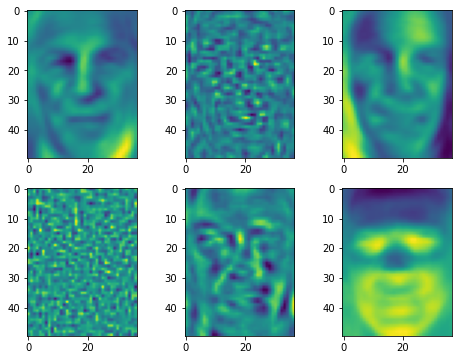

In [6]:
plot_faces(fisherfaces[:,:6])

In [7]:
print('train acc: ', fld_clf.score(X_train_trfm, y_train))
print('test acc: ', fld_clf.score(X_test_trfm, y_test))

train acc:  1.0
test acc:  0.6118012422360248


## Generalized Fisherface ($\alpha=1$)

In [8]:
import sklearn.pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA

fld_clf = sklearn.pipeline.Pipeline(steps=[('fld', GeneralizedFisherLD(n_components=n_classes - 1, alpha=1, shrinkage='auto')),
                                           ('rf', RandomForestClassifier())])
fld_clf.fit(X_train_trfm, y_train)

fisherfaces = fld_clf[0].transformation_matrix_

(<Figure size 576x432 with 6 Axes>, <AxesSubplot:>)

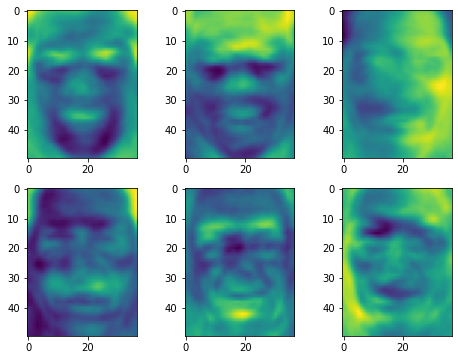

In [9]:
plot_faces(fisherfaces[:,:6])

In [10]:
print('train acc: ', fld_clf.score(X_train_trfm, y_train))
print('test acc: ', fld_clf.score(X_test_trfm, y_test))

train acc:  1.0
test acc:  0.562111801242236


## Generalized Fisherface ($\alpha=0.5$)

We now test an intermediate value of $\alpha$. Note that we don't have to perform PCA first to avoid singular matrices!

In [11]:
import sklearn.pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA

fld_clf = sklearn.pipeline.Pipeline(steps=[('fld', GeneralizedFisherLD(n_components=n_classes - 1, alpha=0.5, shrinkage='auto')),
                                           ('rf', RandomForestClassifier())])
fld_clf.fit(X_train_trfm, y_train)

fisherfaces = fld_clf[0].transformation_matrix_

(<Figure size 576x432 with 6 Axes>, <AxesSubplot:>)

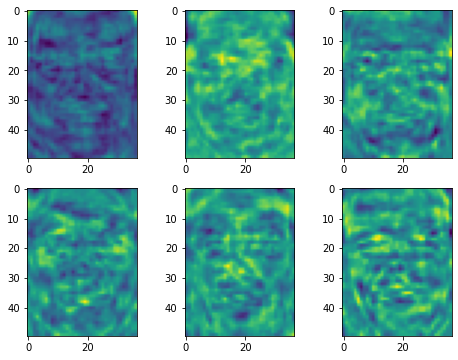

In [12]:
plot_faces(fisherfaces[:,:6])

In [13]:
print('train acc: ', fld_clf.score(X_train_trfm, y_train))
print('test acc: ', fld_clf.score(X_test_trfm, y_test))

train acc:  1.0
test acc:  0.8633540372670807


Note that $\alpha=0.5$ is significantly better than both $\alpha=1$ and $\alpha=0$ (standard fisherface)! This indicates that this generalization has value.

Need to validated performance further.